
Branin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=ce62fa096dc7a3edc797096a5b84b47d701d9808a8e9357102f330e2cd7d709a
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Branin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Branin(x) 2-D:

def objfunc(x1_training, x2_training, a = 1, b = (5.1 / (4 * (np.pi) ** 2)), c = (5 / (np.pi)), r = 6, s = 10, t = (1 / (8 * np.pi))):
        return operator * ((a * (x2_training - b * x1_training ** 2 + c * x1_training - r) ** 2) + 
                 s * (1 - t) * np.cos(x1_training) + s)
        
# Constraints:
lb_x1 = -5 
ub_x1 = +10
lb_x2 = +0 
ub_x2 = +15

# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# True y bounds:
operator = -1
y_lb = 0.397887 # targets global minimum
y_global_orig = y_lb * operator # targets global minimum


# Test data:
x1_test = np.linspace(lb_x1, ub_x1, n_test)
x2_test = np.linspace(lb_x2, ub_x2, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def deriv_se(X, Xstar, sigmaf, l, sigman):
    return cdist(X, Xstar) / (l ** 2) * se(X, Xstar, sigmaf, l, sigman)

def der_covmat(X, Xstar, sigmaf, l, sigman):
      nx = len(X)
      ny = len(Xstar)
      return np.round(np.array([deriv_se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman) for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        dKstar = der_covmat(self.X, Xstar, self.sigmaf, self.l, self.sigman).T
        
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1637079211.1992853

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [ 8.98893195 10.45227242]. 	  -70.52424256621515 	 -5.089934878453152
3      	 [-3.98449353 13.27557148]. 	  -4.859191184895716 	 -4.859191184895716
4      	 [2.98006414 0.05910542]. 	  -6.0230075672454495 	 -4.859191184895716
5      	 [ 5.33580237 15.        ]. 	  -206.4381669221689 	 -4.859191184895716
6      	 [5.84980619 5.67165565]. 	  -39.518846456685544 	 -4.859191184895716
7      	 [-5.          9.40479881]. 	  -73.29201305540373 	 -4.8591911848957

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [ 9.5587047  12.00387527]. 	  -89.09951357262268 	 -6.692051508754487
2      	 [9.59366035 1.69164323]. 	  -1.3984593420568778 	 -1.3984593420568778
3      	 [ 3.24245232 12.67669673]. 	  -110.25694222671481 	 -1.3984593420568778
4      	 [-2.58600765 14.70719421]. 	  -15.7365426981614 	 -1.3984593420568778
5      	 [-4.49478903  0.        ]. 	  -256.41843550309727 	 -1.3984593420568778
6      	 [8.725895   6.41300429]. 	  -22.580114236196877 	 -1.3984593420568778
7      	 [-5.          5.78505952]. 	  -142.73620978185951 	 -1.39845934

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-5. 15.]. 	  -17.508299515778166 	 -17.508299515778166
3      	 [2.64338273 0.68243899]. 	  -5.61793909734835 	 -5.61793909734835
4      	 [10.  0.]. 	  -10.960889035651505 	 -5.61793909734835
5      	 [ 0.17998475 15.        ]. 	  -105.6075359190613 	 -5.61793909734835
6      	 [10.          8.34438631]. 	  -30.474011983257775 	 -5.61793909734835
7      	 [-0.6195202  11.33294215]. 	  -36.28496106529289 	 -5.61793909734835
8      	 [2.269383   4.64046436

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 1.25164457 13.57001383]. 	  -100.61648848019335 	 -7.247126865776948
2      	 [-4.27198795  1.64727177]. 	  -188.41076037632916 	 -7.247126865776948
3      	 [-4.64616955 10.91158353]. 	  -37.15561787434749 	 -7.247126865776948
4      	 [3.91058192 8.49899792]. 	  -48.62596349349736 	 -7.247126865776948
5      	 [1.24885867 0.        ]. 	  -30.7947923644144 	 -7.247126865776948
6      	 [ 6.50701313 15.        ]. 	  -212.19478521338414 	 -7.247126865776948
7      	 [10.         3.9710884]. 	  -2.8804198281203703 	 -2.8804198281203703
8

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [ 8.39476442 14.47736321]. 	  -167.21523769473345 	 -5.96108856337545
3      	 [-4.1375067   7.24495487]. 	  -61.80559119709111 	 -5.96108856337545
4      	 [-5.  0.]. 	  -308.12909601160663 	 -5.96108856337545
5      	 [3.90218642 0.        ]. 	  -6.129536698755416 	 -5.96108856337545
6      	 [ 3.02991629 15.        ]. 	  -160.13370433331355 	 -5.96108856337545
7      	 [10.          4.33727189]. 	  -3.7235379387315213 	 -3.7235379387315213
8      	 [3.

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [ 9.64829531 12.55362889]. 	  -98.32295673962142 	 -15.31731051317483
2      	 [-1.22578785  0.62063252]. 	  -69.8637190838968 	 -15.31731051317483
3      	 [ 4.11366045 15.        ]. 	  -183.10484285176852 	 -15.31731051317483
4      	 [-2.67102288 14.57040418]. 	  -12.985837564809705 	 -12.985837564809705
5      	 [-5.          4.21652744]. 	  -180.96625047114895 	 -12.985837564809705
6      	 [5.44161514 9.98674416]. 	  -94.22618159524357 	 -12.985837564809705
7      	 [3.23829123 1.87841978]. 	  -0.5466720813438801 	 -0.5466720813438

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [-4.97859679  1.38393519]. 	  -260.3293952774437 	 -5.211335324193094
2      	 [ 7.42679792 14.12713902]. 	  -178.37635728719692 	 -5.211335324193094
3      	 [8.08940775 0.35854539]. 	  -9.249625108410735 	 -5.211335324193094
4      	 [-3.39684884  5.54228873]. 	  -54.79871094423047 	 -5.211335324193094
5      	 [4.51732395 5.9162821 ]. 	  -28.11667541280732 	 -5.211335324193094
6      	 [-0.88572207 15.        ]. 	  -72.16042862566053 	 -5.211335324193094
7      	 [10.          3.80987848]. 	  -2.5942635698622443 	 -2.59426356986224

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [9.77124156 0.43098073]. 	  -6.499298445992174 	 -6.499298445992174
2      	 [-4.87537438 11.82874897]. 	  -36.57081146531108 	 -6.499298445992174
3      	 [ 1.38217397 12.68390036]. 	  -86.39656029252868 	 -6.499298445992174
4      	 [-5.          4.93391962]. 	  -162.87055456893222 	 -6.499298445992174
5      	 [4.40861409 1.05852811]. 	  -7.31765987324756 	 -6.499298445992174
6      	 [-1.71652812  8.75489851]. 	  -8.733549018250445 	 -6.499298445992174
7      	 [7.44443989 3.63168661]. 	  -19.208249510441597 	 -6.49929844599217

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [-0.46054038 14.56197292]. 	  -79.4666617606301 	 -3.4640248583909496
3      	 [8.28747407 1.2035024 ]. 	  -6.196385269800155 	 -3.4640248583909496
4      	 [7.59766367 8.71517487]. 	  -66.45862359135464 	 -3.4640248583909496
5      	 [1.7566144  9.14390932]. 	  -38.92895201137776 	 -3.4640248583909496
6      	 [-5.         12.67604545]. 	  -33.075714196778804 	 -3.4640248583909496
7      	 [5.6715956  4.46939079]. 	  -29.020791324624987 	 -3.46402485

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [ 9.16391068 14.81438212]. 	  -158.2412724465548 	 -2.710610964564512
2      	 [9.65621089 6.61160737]. 	  -16.1339423373336 	 -2.710610964564512
3      	 [-3.43070383  6.59407857]. 	  -41.58407101130534 	 -2.710610964564512
4      	 [ 1.02035341 14.99535798]. 	  -124.9536450431274 	 -2.710610964564512
5      	 [-5. 15.]. 	  -17.508299515778166 	 -2.710610964564512
6      	 [1.30780413 7.43219275]. 	  -23.337991150801543 	 -2.710610964564512
7      	 [5.49093003 5.8404457 ]. 	  -38.68828157439221 	 -2.710610964564512
8      	 [10.    

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [6.94653631 0.95529646]. 	  -17.615403152614682 	 -17.615403152614682
2      	 [9.97678471 6.82121545]. 	  -16.579038540907792 	 -16.579038540907792
3      	 [-5. 15.]. 	  -17.508299515778166 	 -16.579038540907792
4      	 [2.40801211 2.48954713]. 	  -3.0501065715386115 	 -3.0501065715386115
5      	 [ 4.54062764 15.        ]. 	  -192.31915583371392 	 -3.0501065715386115
6      	 [5.60829222 5.53295914]. 	  -36.81838224630954 	 -3.0501065715386115
7      	 [-0.54301464 15.        ]. 	  -83.79320939352202 	 -3.0501065715386115
8     

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [10.          4.42358818]. 	  -3.961334736212157 	 -0.5499315281120278
2      	 [ 8.50155249 13.79797306]. 	  -148.00655208378976 	 -0.5499315281120278
3      	 [-4.8799499   0.15657603]. 	  -290.0404981832191 	 -0.5499315281120278
4      	 [5.8072579  8.50643036]. 	  -73.18138418395506 	 -0.5499315281120278
5      	 [3.15872501 0.57007156]. 	  -3.260825771053282 	 -0.5499315281120278
6      	 [ 2.09353067 13.04151801]. 	  -101.38880726759464 	 -0.5499315281120278
7      	 [-0.39744325  3.26093038]. 	  -30.35950541795291 	 -0.54

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-5.         10.55852118]. 	  -56.66525878591628 	 -18.038943061558626
2      	 [-3.36042638  1.3238031 ]. 	  -132.49290788011677 	 -18.038943061558626
3      	 [-0.52648707  6.71273475]. 	  -18.32769423211562 	 -18.038943061558626
4      	 [-0.84237398 15.        ]. 	  -73.66141212210243 	 -18.038943061558626
5      	 [2.39892838 0.        ]. 	  -11.484530246287337 	 -11.484530246287337
6      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
7      	 [-5.          5.87336011]. 	  -140.7303471731284 	 -10.96088903565150

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [10.          6.86255647]. 	  -16.839651757136487 	 -1.4149920024014744
2      	 [-3.61083748  7.85924032]. 	  -32.481990179851884 	 -1.4149920024014744
3      	 [-2.06062727  2.20289552]. 	  -63.62665246304455 	 -1.4149920024014744
4      	 [10.         14.30978652]. 	  -129.78754336484576 	 -1.4149920024014744
5      	 [5.68710915 7.81775739]. 	  -62.71339741866437 	 -1.4149920024014744
6      	 [-5. 15.]. 	  -17.508299515778166 	 -1.4149920024014744
7      	 [2.4230891 0.       ]. 	  -11.193346353138086 	 -1.4149920024014744
8   

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [ 6.5655417  11.87699252]. 	  -134.95011349993544 	 -12.768724532005583
2      	 [-4.77493765 13.49591113]. 	  -19.896906503438096 	 -12.768724532005583
3      	 [ 0.69524818 15.        ]. 	  -118.25691317432663 	 -12.768724532005583
4      	 [2.88475658 0.        ]. 	  -6.88220071543949 	 -6.88220071543949
5      	 [10.         7.3920589]. 	  -21.207359576336543 	 -6.88220071543949
6      	 [4.43909426 6.68421057]. 	  -34.48574674031204 	 -6.88220071543949
7      	 [-1.06518659  0.        ]. 	  -76.1456649953298 	 -6.88220071

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [9.4202829  9.76772141]. 	  -53.637049482645274 	 -2.715864006988424
3      	 [-4.02247103  0.        ]. 	  -213.91242864471565 	 -2.715864006988424
4      	 [3.77207958 8.41836664]. 	  -45.58915671225536 	 -2.715864006988424
5      	 [ 1.00000000e+01 -2.22044605e-16]. 	  -10.960889035651505 	 -2.715864006988424
6      	 [ 0.46219838 12.61300877]. 	  -72.19198261942468 	 -2.715864006988424
7      	 [10.          4.74011175]. 	  -4.9608486466292145 	 -2.71586

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [10.  0.]. 	  -10.960889035651505 	 -10.960889035651505
2      	 [-0.36591853 14.49945231]. 	  -81.3728947682288 	 -10.960889035651505
3      	 [3.74599703 2.35814314]. 	  -2.3563457989420957 	 -2.3563457989420957
4      	 [10.         14.81387187]. 	  -141.4408601588553 	 -2.3563457989420957
5      	 [-5.         11.26990773]. 	  -47.739996251407824 	 -2.3563457989420957
6      	 [10.          5.24001572]. 	  -6.947574144884817 	 -2.3563457989420957
7      	 [ 4.74573296 15.        ]. 	  -196.46731994136059 	 -2.3563457989420957

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-5.          4.86518366]. 	  -164.55978314469397 	 -8.150075223157177
3      	 [ 0.50667591 11.06745993]. 	  -52.509448986258 	 -8.150075223157177
4      	 [4.17705729 0.        ]. 	  -7.680923760130492 	 -7.680923760130492
5      	 [10. 15.]. 	  -145.87219087939556 	 -7.680923760130492
6      	 [0.23184835 5.49205227]. 	  -19.366477269639255 	 -7.680923760130492
7      	 [10.          6.76719321]. 	  -16.11261791544882 	 -7.680923760130492
8      	 [-1.6

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [9.57054653 2.03489665]. 	  -0.8198597583535783 	 -0.8198597583535783
2      	 [4.35401896 5.06360915]. 	  -19.19366062523231 	 -0.8198597583535783
3      	 [-5.          6.34840318]. 	  -130.20673857664974 	 -0.8198597583535783
4      	 [ 0.06622148 15.        ]. 	  -102.47896367552877 	 -0.8198597583535783
5      	 [10. 15.]. 	  -145.87219087939556 	 -0.8198597583535783
6      	 [5.39346729 0.        ]. 	  -17.423927888691484 	 -0.8198597583535783
7      	 [0.45839665 8.54581584]. 	  -29.161829014186026 	 -0.8198597583535783
8     

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-0.46336714  1.1335069 ]. 	  -50.30566093512107 	 -14.042667401507376
2      	 [10.        6.031178]. 	  -11.113265474397442 	 -11.113265474397442
3      	 [9.66447631 0.        ]. 	  -7.879562083249813 	 -7.879562083249813
4      	 [-1.70983375 15.        ]. 	  -43.491518308141394 	 -7.879562083249813
5      	 [-5.          4.71772268]. 	  -168.21560828128608 	 -7.879562083249813
6      	 [5.56194688 7.80586336]. 	  -61.58827450860958 	 -7.879562083249813
7      	 [-5.  0.]. 	  -308.12909601160663 	 -7.879562083249813
8      	

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1637079350.7376652

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.25533007 10.8048674 ]. 	  -56.52874004692151 	 -27.68166689936483
init   	 [-4.99828438  4.53498859]. 	  -172.66531086516164 	 -27.68166689936483
init   	 [-2.79866164  1.38507892]. 	  -102.58290348816024 	 -27.68166689936483
init   	 [-2.20609683  5.18341091]. 	  -28.868064601155666 	 -27.68166689936483
init   	 [0.95151211 8.08225101]. 	  -27.68166689936483 	 -27.68166689936483
1      	 [8.41909995 1.27566317]. 	  -5.089934878453152 	 -5.089934878453152
2      	 [ 8.98893195 10.45227242]. 	  -70.52424256621515 	 -5.089934878453152
3      	 [3.23487616 2.50787376]. 	  -0.5323537645069898 	 -0.5323537645069898
4      	 [-4.67712792 14.21955317]. 	  -13.865244792739254 	 -0.5323537645069898
5      	 [5.51047367 6.69845912]. 	  -47.632552155009456 	 -0.5323537645069898
6      	 [-4.39659383  9.65798091]. 	  -41.08324520653045 	 -0.5323537645069898
7      	 [ 4.549066   14.90869537]. 	  -190.02550896457552 	 -0.5323537

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53992353 0.38889348]. 	  -22.31361308916297 	 -6.692051508754487
init   	 [3.24493717 6.52983589]. 	  -19.233109967858276 	 -6.692051508754487
init   	 [1.30551703 4.95502232]. 	  -13.177851563387286 	 -6.692051508754487
init   	 [-1.93027049  9.2890645 ]. 	  -6.692051508754487 	 -6.692051508754487
init   	 [-0.50517989  4.00240913]. 	  -26.437522758780958 	 -6.692051508754487
1      	 [ 9.5587047  12.00387527]. 	  -89.09951357262268 	 -6.692051508754487
2      	 [9.59366035 1.69164323]. 	  -1.3984593420568778 	 -1.3984593420568778
3      	 [ 3.24245232 12.67669673]. 	  -110.25694222671481 	 -1.3984593420568778
4      	 [-5.  0.]. 	  -308.12909601160663 	 -1.3984593420568778
5      	 [-5.          5.78689537]. 	  -142.6943473977381 	 -1.3984593420568778
6      	 [-3.95509114 14.02730345]. 	  -3.48680055844817 	 -1.3984593420568778
7      	 [6.11283315 0.        ]. 	  -20.66944424547139 	 -1.3984593420568778
8      	 

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.26196854 10.62221734]. 	  -71.68783452098575 	 -18.07886746449891
init   	 [-0.63642892  7.66241408]. 	  -18.07886746449891 	 -18.07886746449891
init   	 [ 8.39420432 13.44439633]. 	  -141.98653529865882 	 -18.07886746449891
init   	 [-3.11622034  3.10864317]. 	  -83.31045707266176 	 -18.07886746449891
init   	 [-4.22799195  6.61214765]. 	  -76.5294170688398 	 -18.07886746449891
1      	 [6.70472147 4.59545299]. 	  -30.726791812855225 	 -18.07886746449891
2      	 [-3.89564496 13.38589781]. 	  -3.6010193697779265 	 -3.6010193697779265
3      	 [1.81560226 3.8838931 ]. 	  -7.793628110072788 	 -3.6010193697779265
4      	 [4.52867141 0.        ]. 	  -10.324684205236581 	 -3.6010193697779265
5      	 [7.39404143 8.91519209]. 	  -72.33310464862045 	 -3.6010193697779265
6      	 [9.93667295 0.73572335]. 	  -6.490387708728175 	 -3.6010193697779265
7      	 [ 0.7273756  14.67607729]. 	  -112.53473754745858 	 -3.60101936977

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [9.50544759 8.20848374]. 	  -32.51676744781521 	 -7.247126865776948
init   	 [ 9.5902654  10.72223991]. 	  -66.20566674364716 	 -7.247126865776948
init   	 [5.46593237 3.24134243]. 	  -20.90089401680587 	 -7.247126865776948
init   	 [9.64411682 0.09345383]. 	  -7.247126865776948 	 -7.247126865776948
init   	 [-1.20526456  6.52187299]. 	  -15.941376982363263 	 -7.247126865776948
1      	 [ 1.25164457 13.57001383]. 	  -100.61648848019335 	 -7.247126865776948
2      	 [-4.27198795  1.64727177]. 	  -188.41076037632916 	 -7.247126865776948
3      	 [1.25064625 0.        ]. 	  -30.759397363449878 	 -7.247126865776948
4      	 [3.06904643 8.83393203]. 	  -42.694938666992996 	 -7.247126865776948
5      	 [-4.73699493 13.33053872]. 	  -19.892240270122997 	 -7.247126865776948
6      	 [-5.          8.73387986]. 	  -84.18508081105834 	 -7.247126865776948
7      	 [ 7.15995113 14.45073253]. 	  -191.00332078453908 	 -7.2471268657769

In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.67010243 13.06098459]. 	  -25.390690545664548 	 -25.311309190989615
init   	 [-1.89921267 13.77916362]. 	  -25.311309190989615 	 -25.311309190989615
init   	 [2.32616783 9.17615794]. 	  -41.60147975414021 	 -25.311309190989615
init   	 [6.48861785 7.77626982]. 	  -63.81281921768236 	 -25.311309190989615
init   	 [-0.54799248  2.81581843]. 	  -34.966203644931994 	 -25.311309190989615
1      	 [8.84124421 0.03321319]. 	  -5.96108856337545 	 -5.96108856337545
2      	 [ 8.39476442 14.47736321]. 	  -167.21523769473345 	 -5.96108856337545
3      	 [-5.          8.61476707]. 	  -86.21310380799248 	 -5.96108856337545
4      	 [-5.  0.]. 	  -308.12909601160663 	 -5.96108856337545
5      	 [4.62914567 2.59249137]. 	  -10.621788692320402 	 -5.96108856337545
6      	 [ 4.04596434 13.05594086]. 	  -133.58142930492147 	 -5.96108856337545
7      	 [1.95186245 0.        ]. 	  -17.891686000049518 	 -5.96108856337545
8      	 [8.731

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [8.39290227 4.97969708]. 	  -15.553860636684597 	 -15.31731051317483
init   	 [7.31843685 0.62544939]. 	  -15.31731051317483 	 -15.31731051317483
init   	 [-3.3851498   8.92578096]. 	  -16.222288919361837 	 -15.31731051317483
init   	 [2.94726043 6.28211143]. 	  -15.406373581304088 	 -15.31731051317483
init   	 [0.03111774 9.33779148]. 	  -31.07053245856209 	 -15.31731051317483
1      	 [ 9.64829531 12.55362889]. 	  -98.32295673962142 	 -15.31731051317483
2      	 [-1.22578785  0.62063252]. 	  -69.8637190838968 	 -15.31731051317483
3      	 [ 4.3472355  14.59607381]. 	  -177.488242573035 	 -15.31731051317483
4      	 [-1.77014503 13.95364881]. 	  -30.486400153319025 	 -15.31731051317483
5      	 [-5.          4.20058313]. 	  -181.38012660086034 	 -15.31731051317483
6      	 [6.24583571 9.13285343]. 	  -84.13835605567847 	 -15.31731051317483
7      	 [3.23427116 0.        ]. 	  -5.295977322064076 	 -5.295977322064076
8  

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.85537566 11.69878188]. 	  -8.299317850233932 	 -5.211335324193094
init   	 [ 1.57613847 10.85197767]. 	  -59.50408380701259 	 -5.211335324193094
init   	 [9.66984268 8.07743806]. 	  -29.714921414987273 	 -5.211335324193094
init   	 [2.51680695 1.080767  ]. 	  -5.211335324193094 	 -5.211335324193094
init   	 [-0.9734153   7.49823751]. 	  -15.431057204948033 	 -5.211335324193094
1      	 [-4.97859679  1.38393519]. 	  -260.3293952774437 	 -5.211335324193094
2      	 [ 7.42679792 14.12713902]. 	  -178.37635728719692 	 -5.211335324193094
3      	 [8.08940775 0.35854539]. 	  -9.249625108410735 	 -5.211335324193094
4      	 [-3.39684884  5.54228873]. 	  -54.79871094423047 	 -5.211335324193094
5      	 [4.93227297 5.49401133]. 	  -29.74492288492527 	 -5.211335324193094
6      	 [-4.91537069 14.98812452]. 	  -15.762184053004502 	 -5.211335324193094
7      	 [ 0.41036662 14.84871201]. 	  -108.67673451031358 	 -5.2113353241930

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 8.10144104 14.52810994]. 	  -175.17297136347514 	 -15.416245468470875
init   	 [8.0379181  7.96283537]. 	  -49.32173799887473 	 -15.416245468470875
init   	 [-1.50907508  0.17098206]. 	  -83.26753461673219 	 -15.416245468470875
init   	 [1.45703227 6.0352704 ]. 	  -15.416245468470875 	 -15.416245468470875
init   	 [2.84012007 7.17587694]. 	  -22.49093277852639 	 -15.416245468470875
1      	 [9.77124156 0.43098073]. 	  -6.499298445992174 	 -6.499298445992174
2      	 [-4.87537438 11.82874897]. 	  -36.57081146531108 	 -6.499298445992174
3      	 [-4.4558775  6.2682523]. 	  -95.7065873173797 	 -6.499298445992174
4      	 [4.53823978 0.93210687]. 	  -8.591967052208886 	 -6.499298445992174
5      	 [-0.10664759 12.3093941 ]. 	  -57.22493359528529 	 -6.499298445992174
6      	 [7.40916805 3.51956372]. 	  -19.059812492466705 	 -6.499298445992174
7      	 [ 4.79164746 10.26335952]. 	  -90.3880656137853 	 -6.499298445992174
8 

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.84438769  7.52811888]. 	  -96.15564306553264 	 -3.4640248583909496
init   	 [2.4365994  2.00744293]. 	  -3.4640248583909496 	 -3.4640248583909496
init   	 [-2.86833372  3.27838013]. 	  -70.46930174488207 	 -3.4640248583909496
init   	 [1.27762271 3.72151753]. 	  -12.982825924833865 	 -3.4640248583909496
init   	 [-3.73910523  5.1824796 ]. 	  -75.58547400560856 	 -3.4640248583909496
1      	 [ 7.05609655 14.75038872]. 	  -200.4388688685465 	 -3.4640248583909496
2      	 [-0.46054038 14.56197292]. 	  -79.4666617606301 	 -3.4640248583909496
3      	 [8.28747407 1.2035024 ]. 	  -6.196385269800155 	 -3.4640248583909496
4      	 [4.13843533 9.54649574]. 	  -67.52115057466781 	 -3.4640248583909496
5      	 [9.67993735 5.53971063]. 	  -8.780439004071493 	 -3.4640248583909496
6      	 [5.69614675 4.2958879 ]. 	  -28.043820974806252 	 -3.4640248583909496
7      	 [-4.25034011 11.93015171]. 	  -15.757306676398883 	 -3.46402485

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.56980965 0.31127924]. 	  -19.863985024602144 	 -2.710610964564512
init   	 [ 4.50472352 11.23205824]. 	  -103.66999147252169 	 -2.710610964564512
init   	 [2.47760518 3.37194968]. 	  -2.710610964564512 	 -2.710610964564512
init   	 [-2.02905703 11.40796068]. 	  -8.463930835255017 	 -2.710610964564512
init   	 [-2.46333745  1.32509721]. 	  -90.49481266026973 	 -2.710610964564512
1      	 [ 9.16391068 14.81438212]. 	  -158.2412724465548 	 -2.710610964564512
2      	 [9.65621089 6.61160737]. 	  -16.1339423373336 	 -2.710610964564512
3      	 [-3.43070383  6.59407857]. 	  -41.58407106439376 	 -2.710610964564512
4      	 [5.88487168 4.7885443 ]. 	  -32.398178843786084 	 -2.710610964564512
5      	 [-4.09924692 14.83375461]. 	  -4.493827434733729 	 -2.710610964564512
6      	 [1.97278026 0.        ]. 	  -17.55293078007332 	 -2.710610964564512
7      	 [2.60674153 6.25926116]. 	  -14.20116807754205 	 -2.710610964564512
8   

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.29595467  0.29212862]. 	  -104.49282729548965 	 -22.37435843952312
init   	 [ 1.9482779  10.87400894]. 	  -62.47758067812407 	 -22.37435843952312
init   	 [1.30305407 7.28140647]. 	  -22.37435843952312 	 -22.37435843952312
init   	 [-4.80828778  7.31057411]. 	  -97.94503054415523 	 -22.37435843952312
init   	 [ 9.12709979 12.76192634]. 	  -111.62900800771942 	 -22.37435843952312
1      	 [6.94653631 0.95529646]. 	  -17.615403152614682 	 -17.615403152614682
2      	 [7.3688317  7.13768046]. 	  -48.71045399942362 	 -17.615403152614682
3      	 [2.46118385 0.        ]. 	  -10.746816210904509 	 -10.746816210904509
4      	 [2.30635971 3.64636848]. 	  -3.9536877206008034 	 -3.9536877206008034
5      	 [-3.42208896 11.32925449]. 	  -3.4300860679631757 	 -3.4300860679631757
6      	 [-1.86533596  4.67610427]. 	  -29.70064013578507 	 -3.4300860679631757
7      	 [-0.77255064 14.09983832]. 	  -63.02373645523099 	 -3.43008606

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.68755736 11.10074545]. 	  -1.3827702760021356 	 -0.5499315281120278
init   	 [-1.05027477  8.0060909 ]. 	  -14.81231853080056 	 -0.5499315281120278
init   	 [-4.78137556 13.78120512]. 	  -18.401131000214548 	 -0.5499315281120278
init   	 [8.51072281 0.50132141]. 	  -5.855172364344769 	 -0.5499315281120278
init   	 [9.35424004 2.05813982]. 	  -0.5499315281120278 	 -0.5499315281120278
1      	 [9.43895355 6.28875405]. 	  -14.852312468115107 	 -0.5499315281120278
2      	 [ 5.04936449 13.86496049]. 	  -172.12573102553992 	 -0.5499315281120278
3      	 [-4.8799499   0.15657603]. 	  -290.0404981832191 	 -0.5499315281120278
4      	 [3.2079129 0.4609552]. 	  -3.5267866001329438 	 -0.5499315281120278
5      	 [4.20592974 8.1379563 ]. 	  -48.20076152688687 	 -0.5499315281120278
6      	 [-5.          5.51572304]. 	  -148.95086281451762 	 -0.5499315281120278
7      	 [ 9.98185613 14.45397276]. 	  -133.38707816968864 	 -0.549

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [6.66553616 3.5631183 ]. 	  -24.823670200298267 	 -18.038943061558626
init   	 [ 7.36417799 14.48623797]. 	  -188.7803334745195 	 -18.038943061558626
init   	 [9.58901671 6.80173871]. 	  -18.038943061558626 	 -18.038943061558626
init   	 [ 4.13563694 11.63289772]. 	  -104.87319703906111 	 -18.038943061558626
init   	 [ 4.62420017 10.83027344]. 	  -98.03271225790056 	 -18.038943061558626
1      	 [-5.  0.]. 	  -308.12909601160663 	 -18.038943061558626
2      	 [-3.06562888 11.40851515]. 	  -0.8943531028899869 	 -0.8943531028899869
3      	 [-0.77721745  5.55115316]. 	  -19.956248293009427 	 -0.8943531028899869
4      	 [2.59188287 0.        ]. 	  -9.335093435946185 	 -0.8943531028899869
5      	 [-5.          7.42675689]. 	  -107.99312701809245 	 -0.8943531028899869
6      	 [-0.06883273 13.37848162]. 	  -72.40783366532642 	 -0.8943531028899869
7      	 [3.48746726 6.23886957]. 	  -18.759310662148607 	 -0.894353102889986

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.70915016 11.59747578]. 	  -81.58264375064097 	 -1.4149920024014744
init   	 [8.05641529 0.12070423]. 	  -10.148649076616518 	 -1.4149920024014744
init   	 [-0.35396112 14.36405609]. 	  -79.6056658956529 	 -1.4149920024014744
init   	 [2.69675068 4.77426637]. 	  -5.855607664288365 	 -1.4149920024014744
init   	 [3.08799906 3.31882414]. 	  -1.4149920024014744 	 -1.4149920024014744
1      	 [-4.22572169  4.73878507]. 	  -111.46482334173054 	 -1.4149920024014744
2      	 [ 9.02510452 14.92575454]. 	  -164.15736583327134 	 -1.4149920024014744
3      	 [8.4415984  6.61360555]. 	  -28.132050221972662 	 -1.4149920024014744
4      	 [-0.41451997  0.        ]. 	  -63.43704758981675 	 -1.4149920024014744
5      	 [-2.5114004   9.49817376]. 	  -3.9679347463509593 	 -1.4149920024014744
6      	 [-5.  0.]. 	  -308.12909601160663 	 -1.4149920024014744
7      	 [ 7.00852198 10.77384202]. 	  -109.01486032891644 	 -1.4149920024014744

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [7.73226546 2.68343887]. 	  -12.768724532005583 	 -12.768724532005583
init   	 [-4.18455179  5.42307669]. 	  -95.39334176626551 	 -12.768724532005583
init   	 [-0.86898607  7.95000337]. 	  -16.419487782111716 	 -12.768724532005583
init   	 [-0.41121626  4.56711539]. 	  -23.250362743740954 	 -12.768724532005583
init   	 [-3.32388086  3.74848521]. 	  -80.99796277938532 	 -12.768724532005583
1      	 [ 6.5655417  11.87699252]. 	  -134.95011349993544 	 -12.768724532005583
2      	 [-4.77493765 13.49591113]. 	  -19.896906503438096 	 -12.768724532005583
3      	 [2.96188257 0.        ]. 	  -6.405636570380561 	 -6.405636570380561
4      	 [4.35167025 6.82761215]. 	  -34.77668965630743 	 -6.405636570380561
5      	 [-1.18391645  0.        ]. 	  -78.67249780862176 	 -6.405636570380561
6      	 [ 0.90953883 12.88977364]. 	  -83.63755820713833 	 -6.405636570380561
7      	 [9.8673558  5.57328662]. 	  -8.611202245125636 	 -6.405636

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.65063381  7.84745012]. 	  -10.514702126319445 	 -2.715864006988424
init   	 [3.26052185 0.68402925]. 	  -2.715864006988424 	 -2.715864006988424
init   	 [0.41093253 3.34621413]. 	  -22.889515127492515 	 -2.715864006988424
init   	 [5.33089243 2.45597138]. 	  -17.178157611778595 	 -2.715864006988424
init   	 [-3.945127  14.1151629]. 	  -3.3649224341694195 	 -2.715864006988424
1      	 [ 5.63879248 14.58068289]. 	  -198.51319639462758 	 -2.715864006988424
2      	 [-5.  0.]. 	  -308.12909601160663 	 -2.715864006988424
3      	 [4.39600939 7.43435868]. 	  -42.22899400142327 	 -2.715864006988424
4      	 [ 1.38440313 11.43739079]. 	  -66.43802178283727 	 -2.715864006988424
5      	 [-5.         10.18834374]. 	  -61.709983235409 	 -2.715864006988424
6      	 [9.91844219 8.81695252]. 	  -36.28422213736768 	 -2.715864006988424
7      	 [9.25810749 0.8143285 ]. 	  -2.8525180892541595 	 -2.715864006988424
8      	 [-3.892201

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.58002496  7.95880133]. 	  -19.016141117164256 	 -19.016141117164256
init   	 [-2.1271882   1.01850537]. 	  -85.05949339404415 	 -19.016141117164256
init   	 [6.8047819  9.84500283]. 	  -93.89792695202516 	 -19.016141117164256
init   	 [4.56281344 8.63404341]. 	  -60.50217141122736 	 -19.016141117164256
init   	 [-4.41405626  5.36720407]. 	  -110.70834086593878 	 -19.016141117164256
1      	 [9.76575296 0.98553483]. 	  -4.1623278326263815 	 -4.1623278326263815
2      	 [-0.36591853 14.49945231]. 	  -81.3728947682288 	 -4.1623278326263815
3      	 [3.74599703 2.35814314]. 	  -2.3563457989420957 	 -2.3563457989420957
4      	 [-4.56064808 10.77631926]. 	  -35.26868616619298 	 -2.3563457989420957
5      	 [ 4.90329936 14.65548099]. 	  -190.13600881702828 	 -2.3563457989420957
6      	 [0.85367212 4.05210631]. 	  -16.77770279133858 	 -2.3563457989420957
7      	 [7.02200832 4.75869118]. 	  -29.805254325784624 	 -2.356345

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.75561363 7.58180061]. 	  -49.215059064668324 	 -8.150075223157177
init   	 [8.17902206 2.72760338]. 	  -8.150075223157177 	 -8.150075223157177
init   	 [ 7.78349603 11.25204429]. 	  -106.98107856533271 	 -8.150075223157177
init   	 [ 4.99152501 14.81843172]. 	  -196.08601750690153 	 -8.150075223157177
init   	 [-1.14547366  0.42458888]. 	  -71.23649635555944 	 -8.150075223157177
1      	 [-4.83474958 11.77354131]. 	  -35.58412906267954 	 -8.150075223157177
2      	 [-0.87796973  6.69249067]. 	  -16.780102991704005 	 -8.150075223157177
3      	 [2.26269696 3.67615218]. 	  -4.253225571797001 	 -4.253225571797001
4      	 [-5.          4.00526121]. 	  -186.4914815995587 	 -4.253225571797001
5      	 [-0.12756076 10.65515995]. 	  -39.32694072849436 	 -4.253225571797001
6      	 [4.52096626 0.        ]. 	  -10.26139395591312 	 -4.253225571797001
7      	 [-5.          8.11305331]. 	  -95.06679599404121 	 -4.25322557179700

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.53699597 11.41874575]. 	  -4.475608269502271 	 -4.475608269502271
init   	 [-1.2959304   2.07197531]. 	  -51.13947793770689 	 -4.475608269502271
init   	 [-0.02830155  1.24499348]. 	  -42.63973921760034 	 -4.475608269502271
init   	 [ 5.07965622 12.09890697]. 	  -131.17235664506808 	 -4.475608269502271
init   	 [9.74112872 9.53491102]. 	  -46.84458913925112 	 -4.475608269502271
1      	 [9.57054653 2.03489665]. 	  -0.8198597583535783 	 -0.8198597583535783
2      	 [-5.          6.34185149]. 	  -130.3488086415812 	 -0.8198597583535783
3      	 [1.78714444 7.26678851]. 	  -21.61779512516127 	 -0.8198597583535783
4      	 [5.20684492 0.        ]. 	  -16.03390779888049 	 -0.8198597583535783
5      	 [6.89355787 4.96911058]. 	  -32.32011187977322 	 -0.8198597583535783
6      	 [ 0.3130287  13.28550308]. 	  -79.52464605053588 	 -0.8198597583535783
7      	 [-5.  0.]. 	  -308.12909601160663 	 -0.8198597583535783
8      	 [

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.82196202 13.46570592]. 	  -138.5264349938869 	 -14.042667401507376
init   	 [ 8.37296094 12.23756216]. 	  -115.63178540512689 	 -14.042667401507376
init   	 [-4.46165622 10.37636373]. 	  -35.66708529307584 	 -14.042667401507376
init   	 [0.68021413 7.77766418]. 	  -25.307769914281764 	 -14.042667401507376
init   	 [4.86927198 2.90775327]. 	  -14.042667401507376 	 -14.042667401507376
1      	 [-5.  0.]. 	  -308.12909601160663 	 -14.042667401507376
2      	 [0.68810597 0.        ]. 	  -42.0784382342882 	 -14.042667401507376
3      	 [-4.96700398  5.4161468 ]. 	  -148.7524655655216 	 -14.042667401507376
4      	 [9.27672345 3.31678741]. 	  -1.4319279865835988 	 -1.4319279865835988
5      	 [6.71208089 7.30812335]. 	  -56.81003806811312 	 -1.4319279865835988
6      	 [8.10793251 0.        ]. 	  -10.110133441962933 	 -1.4319279865835988
7      	 [-4.32298919 14.99123565]. 	  -6.4466772514526305 	 -1.4319279865835988
8   

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

577.1261713504791

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(1.4954411414241748, -3.7098639067316648)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(0.0005721783316311656, -1.9490131153703354)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(1.0383875198920414, 0.6898024258481509)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(-1.6142413222639251, 0.7520103116245644)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(0.8522190672362863, -0.11800119797963454)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(-1.9052524213952455, -1.1217757902957497)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(0.7868089888471265, -1.0457888275438645)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(1.797177111480606, 1.8085201290028612)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(0.5890523437213153, 0.5560795467788634)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(0.606281946201423, 0.5809737356446687)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(-0.5207374833902783, 0.9010367961576701)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(-0.06557412435572195, 1.1406813772857063)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(0.49339894345476154, -4.999903128444473)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(0.4451925414611061, -1.7171078072277561)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(1.118969763010599, 0.5190611646945158)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.2488072837175237, 0.5830687008725935)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(0.48248490604152217, 0.3736586777309275)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(1.6933290643071575, 0.9445861564372652)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(-4.169759561878367, -0.8628145206943092)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(1.5706871896702388, 0.03347441416291977)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

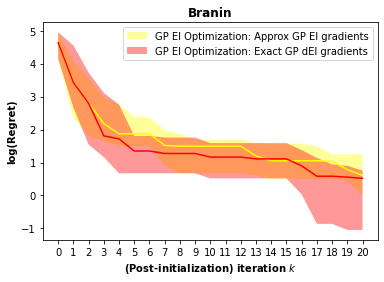

In [102]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI Optimization: Approx GP EI gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP EI Optimization: Exact GP dEI gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(139.53822922706604, 577.1261713504791)